In [54]:
%pip install nltk requests pandas scikit-learn matplotlib 

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\JTYAP\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [55]:
import requests
import csv
import pandas as pd
import nltk
nltk.download('vader_lexicon')
# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# import tweepy  # for Twitter API
# import praw  # for Reddit API
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JTYAP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JTYAP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JTYAP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JTYAP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text   source  \
0  Bitcoin in the bush - the crypto mine in remot...  NewsAPI   
1  Trump Signs Executive Order Creating a Strateg...  NewsAPI   
2  Cathie Wood says people are going to learn the...  NewsAPI   
3  Trump Signs Order To Establish Strategic Bitco...  NewsAPI   
4  The Quantum Apocalypse Is Coming. Be Very Afra...  NewsAPI   

                                        cleaned_text sentiment   score  
0  bitcoin in the bush the crypto mine in remote ...  Positive  0.2500  
1  trump signs executive order creating a strateg...  Positive  0.2960  
2  cathie wood says people are going to learn the...  Negative -0.4588  
3  trump signs order to establish strategic bitco...   Neutral  0.0000  
4  the quantum apocalypse is coming be very afrai...  Positive  0.4215  


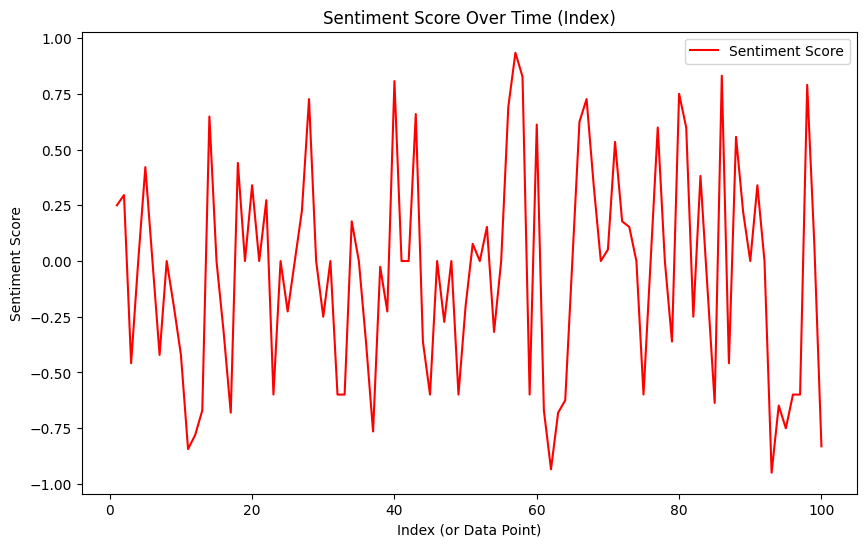

In [56]:
# Step 1: Data Collection
def collect_data_from_newsapi(api_key, query="Bitcoin"):
    api_key = 'e87e7b8950fd4d0b8db934b608a90ea2'
    url = f'https://newsapi.org/v2/everything?q={query}&apiKey={api_key}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        articles = data['articles']
        
        article_data = []
        for article in articles:
            # Ensure title and description are strings (use empty string if None)
            title = article.get('title', '')
            description = article.get('description', '')
            
            # Concatenate title and description
            text = (title or '') + " " + (description or '')
            
            # Append only if the text is not empty
            if text.strip():
                article_data.append({'text': text, 'source': 'NewsAPI'})
        
        return article_data
    else:
        return []

# def collect_data_from_twitter(api_key, api_secret_key, access_token, access_token_secret, query="Bitcoin"):
#     # Twitter Authentication
#     auth = tweepy.OAuth1UserHandler(consumer_key=api_key, consumer_secret=api_secret_key, 
#                                      access_token=access_token, access_token_secret=access_token_secret)
#     api = tweepy.API(auth)

#     # Fetch tweets related to Bitcoin
#     tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en").items(100)

#     tweet_data = []
#     for tweet in tweets:
#         tweet_data.append({'text': tweet.text, 'source': 'Twitter'})

#     return tweet_data


# def collect_data_from_reddit(client_id, client_secret, user_agent, query="Bitcoin"):
#     # Reddit Authentication
#     reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
    
#     # Search for Reddit posts related to Bitcoin
#     submissions = reddit.subreddit('Bitcoin').search(query, limit=100)
    
#     reddit_data = []
#     for submission in submissions:
#         reddit_data.append({'text': submission.title + " " + submission.selftext, 'source': 'Reddit'})
    
#     return reddit_data


# def collect_data_from_coindesk(api_key, query="Bitcoin"):
#     url = f'https://api.coindesk.com/v1/bpi/currentprice/{query}.json'
#     response = requests.get(url)
    
#     if response.status_code == 200:
#         data = response.json()
#         article_data = [{'text': data['bpi']['USD']['description'], 'source': 'CoinDesk'}]
#         return article_data
#     else:
#         return []


# Step 2: Preprocess Data
def preprocess_text(text):
    # Remove URLs, special characters, and stopwords (basic example)
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\W+', ' ', text)  # remove special characters
    text = text.lower()
    return text


# Step 3: Sentiment Analysis
def analyze_sentiment_vader(text):
    # Using VADER Sentiment Analyzer
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return sentiment, compound_score


def analyze_sentiment_textblob(text):
    # Using TextBlob for Sentiment Analysis
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        sentiment = 'Positive'
    elif polarity < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return sentiment, polarity


# Step 4: Aggregating Sentiment Results and Saving to CSV
def aggregate_sentiment_data(data, file_name="sentiment_data.csv"):
    # Convert to DataFrame for easy aggregation
    df = pd.DataFrame(data)
    
    # Preprocess text
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    # Perform Sentiment Analysis
    df['sentiment'], df['score'] = zip(*df['cleaned_text'].apply(analyze_sentiment_vader))
    
    # Save the results to CSV
    df.to_csv(file_name, index=False)
    
    return df

# Step 5: Visualize or Correlate Sentiment with Bitcoin Price (For simplicity, assume we have price data)
def visualize_sentiment_over_time(sentiment_df):
    # If no timestamp, we will use a simple count/index
    sentiment_df['index'] = range(1, len(sentiment_df) + 1)
    
    # Plot sentiment scores over the generated index
    plt.figure(figsize=(10,6))
    plt.plot(sentiment_df['index'], sentiment_df['score'], label='Sentiment Score', color='r')
    
    # Add labels and title
    plt.xlabel('Index (or Data Point)')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Score Over Time (Index)')
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()


# Collect data from NewsAPI
newsapi_data = collect_data_from_newsapi(api_key="e87e7b8950fd4d0b8db934b608a90ea2")    

# # Collect data from Twitter
# twitter_data = collect_data_from_twitter(api_key="your_twitter_api_key", 
#                                          api_secret_key="your_twitter_api_secret_key", 
#                                          access_token="your_access_token", 
#                                          access_token_secret="your_access_token_secret")

# # Collect data from Reddit
# reddit_data = collect_data_from_reddit(client_id="your_reddit_client_id", 
#                                        client_secret="your_reddit_client_secret", 
#                                        user_agent="your_reddit_user_agent")

# # Collect data from CoinDesk
# coindesk_data = collect_data_from_coindesk(api_key="your_coindesk_api_key")

# Combine all data
all_data = newsapi_data

# Aggregate sentiment data and save to CSV
sentiment_df = aggregate_sentiment_data(all_data, file_name="sentiment_data.csv")

# Print the head of the dataframe
print(sentiment_df.head())

visualize_sentiment_over_time(sentiment_df)


